4244 degerde 2346 tanesi bulundu
Dogruluk = 0.5527803958529689


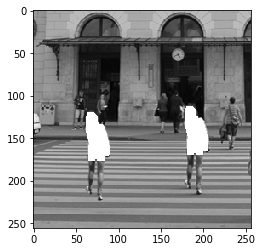

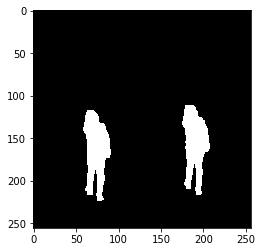

In [35]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import dct

# ZİG-ZAG TASARIMI ( İLK 16 DEGER ALINIR )
def zig_zag(input_matrix, block_size):
    z = np.empty(block_size*block_size)
    index = -1
    bound = 0
    for i in range(0, 2 * block_size -1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                z[index] = int(input_matrix[j, i-j])
            else:
                z[index] = int(input_matrix[i-j, j])
    return z[:16]

# ÖKLİD FONKSİYONU
def euclidian(array1, array2):
    toplam = 0
    for i in range(len(array1)):
        toplam += (int(array1[i]) - int(array2[i])) ** 2 
    return toplam ** 0.5

# RESİM YOLLARI
#im = cv2.imread("f1.png", 0)
#im = cv2.imread("f1_90.png", 0)
im = cv2.imread("f2.png", 0)
#im = cv2.imread("f2_90.png", 0)

blok_boyutu = 8 # BLOK ARALIĞI
yukseklik = im.shape[0] # SATIR SAYISI
genislik = im.shape[1] # SUTUN SAYISI

bloklar = np.zeros((yukseklik, genislik, blok_boyutu, blok_boyutu))
dct_blogu = np.zeros_like(bloklar) # bloklar ile aynı boyuttadır.
# (256,256,8,8)

#quantalama_tablosu = np.array([1, 1, 1, 2, 1, 2, 4, 2, 2, 4, 8, 4, 2, 4, 8, 16])
quantalama_tablosu = 16
zigzag_vektorleri = np.zeros((dct_blogu.shape[0] * dct_blogu.shape[1], 18))
# boyut: [256*256,(16+2)] = (65536, 18)

# floor: Dizi öğelerinin tabanını döndürür.
for i in range(yukseklik - blok_boyutu + 1):
    for j in range(genislik - blok_boyutu + 1):
        bloklar[i, j] = im[i : i + blok_boyutu, j : j + blok_boyutu] # RESİMDEKİ BLOK BÖLGESİNİ BULAN YERDİR.
        dct_blogu[i, j] = dct( dct( bloklar[i, j], type=3, axis=0 ), type=3, axis=1) # DCT3 MODU UYGULANDI.
        zigzag_vektorleri[i * genislik + j][:16] = np.floor(zig_zag(dct_blogu[i, j], blok_boyutu) / quantalama_tablosu)
        zigzag_vektorleri[i * genislik + j][16] = i # X konum bilgisi
        zigzag_vektorleri[i * genislik + j][17] = j # Y konum bilgisi

# VEKTORLER SIRALANMAKTADIR.
zigzag_vektorleri = zigzag_vektorleri.tolist() # DİZİ LİSTEYE CEVRİLDİ
zigzag_vektorleri = np.array(sorted(zigzag_vektorleri, key = lambda zigzag_vektorleri: zigzag_vektorleri[1]))

# KUCUK RESIM BOYUTU : 256 x 256
# BLOKLARIN BOYUTU : 256 x 256 x 8 x 8
# DCT BOYUTU : 256 x 256 x 8 x 8
# ZIGZAG VEKTORLERI : (256*256) x 18

# DEGER SETLEMELERİ
bakilacak_vektor = 10
benzerlik_esigi = 0.7
yakinlik_esigi = 5

# SIRALI ZIGZAG VEKTORLERI UZERINDE İSLEM KISMIDIR.
for i in range(zigzag_vektorleri.shape[0] - bakilacak_vektor):
    for j in range(1, bakilacak_vektor):
        dist = euclidian(zigzag_vektorleri[i][:16], zigzag_vektorleri[i + j][:16])
        if(dist < benzerlik_esigi):
            #if(i % 500 == 0):
                #print("{}/{} satir tamamlandi".format(i, zigzag_vektorleri.shape[0]))
            yakinlikX = zigzag_vektorleri[i][16] - zigzag_vektorleri[i + j][16]
            yakinlikY = zigzag_vektorleri[i][17] - zigzag_vektorleri[i + j][17]
            if(((yakinlikX ** 2 + yakinlikY ** 2) ** 0.5) > yakinlik_esigi):
                im[int(zigzag_vektorleri[i][16]) : int(zigzag_vektorleri[i][16]) + blok_boyutu, 
                  int(zigzag_vektorleri[i][17]) : int(zigzag_vektorleri[i][17]) + blok_boyutu] = 255
                im[int(zigzag_vektorleri[i + j][16]) : int(zigzag_vektorleri[i + j][16]) + blok_boyutu, 
                  int(zigzag_vektorleri[i + j][17]) : int(zigzag_vektorleri[i + j][17]) + blok_boyutu] = 255

plt.figure()
plt.imshow(im, cmap="gray")

# DOGRULUK DEGERİ BULMA
#ground_truth = cv2.imread("forged1_maske.png", 0)
ground_truth = cv2.imread("forged2_maske.png", 0)

plt.figure()
plt.imshow(ground_truth, cmap="gray")

eslesme = 0
toplam_deger = np.unique(ground_truth, return_counts=True)[1][1] # TOPLAM KOPYALANAN PİKSEL SAYISI

for i in range(ground_truth.shape[0]):
    for j in range(ground_truth.shape[1]):
        if((ground_truth[i, j] == im[i, j]) and (im[i, j] == 255)):
            eslesme += 1

print("{} degerde {} tanesi bulundu".format(toplam_deger, eslesme))
print("Dogruluk = {}".format(eslesme/toplam_deger))

In [27]:
zigzag_vektorleri.shape[0]

65536

In [7]:
im.shape

(256, 256)

In [22]:
np.unique(ground_truth, return_counts=True)[0][0]

0